In [1]:
#!wget https://zenodo.org/record/4281122/files/AI_Ready_DMSP_Data.csv

## Importing Importing Libraries

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from os.path import isfile, join
from sys import getsizeof
import glob

from random import *

import time

from pickle import dump
import joblib

# from keras import backend as K
import keras
from keras import utils, models, layers, optimizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.layers import Dense, GRU, BatchNormalization, Activation, LSTM, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the dataset

In [3]:
# Reading the csv file
df = pd.read_csv('/content/drive/MyDrive/AI_Ready_DMSP_Data.csv')

In [4]:
# printing first few rows of the dataset
df.head()

,Datetimes,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,ID_SC,sin_ut,cos_ut,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,1987-01-12 12:57:00,51.143220,5.664024,2.057827e+08,0.411230,39.89341,0.411485,6.0,-0.246153,-0.969231,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1,1987-01-12 12:58:00,54.137207,5.535848,2.509837e+08,0.478268,40.82392,0.478568,6.0,-0.250380,-0.968148,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
2,1987-01-12 13:01:00,62.928176,5.031172,4.469146e+08,0.603362,143.77360,0.604023,6.0,-0.263031,-0.964787,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
3,1987-01-12 13:02:00,65.719631,4.794780,1.934849e+10,0.103648,820.36560,0.103671,6.0,-0.267238,-0.963630,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
4,1987-01-12 13:03:00,68.392364,4.507448,3.913337e+11,0.114959,5291.57100,0.114959,6.0,-0.271440,-0.962455,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015


In [5]:
df.tail()

,Datetimes,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,ID_SC,sin_ut,cos_ut,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
77362,2001-08-14 00:07:00,57.812931,21.240201,389180700.0,0.248978,41.87141,0.380675,14.0,0.030539,0.999534,...,59.0,-17.0,43.0,1.0,-0.59,444.7,-443.8,2.78,9239.808661,1838.558494
77363,2001-08-14 00:08:00,55.052864,21.138485,194233100.0,0.318602,37.83175,0.473438,14.0,0.034899,0.999391,...,59.0,-17.0,43.0,1.0,-0.59,444.7,-443.8,2.78,9239.808661,1838.558494
77364,2001-08-14 00:10:00,49.510741,20.968127,99445080.0,0.441666,32.72413,0.635324,14.0,0.043619,0.999048,...,70.0,-20.0,50.0,3.0,-0.38,424.6,-423.8,2.11,21965.214456,6469.936395
77365,2001-08-14 00:11:00,46.750041,20.896789,176703900.0,0.516674,118.97360,0.726030,14.0,0.047978,0.998848,...,70.0,-20.0,50.0,3.0,-0.38,424.6,-423.8,2.11,21965.214456,6469.936395
77366,2001-08-14 00:40:00,58.842792,20.370770,104659900.0,0.392372,56.71277,0.597364,14.0,0.173648,0.984808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.shape

(77367, 154)

In [7]:
# creating the copy of the dataset
df_cumulative = df.copy()

In [8]:
# changing the date column into datetime format
df_cumulative = df_cumulative.set_index('Datetimes')
df_cumulative.index = pd.to_datetime(df_cumulative.index)

In [9]:
# list the columns
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'SC_AACGM_LTIME',
 'ELE_TOTAL_ENERGY_FLUX',
 'ELE_TOTAL_ENERGY_FLUX_STD',
 'ELE_AVG_ENERGY',
 'ELE_AVG_ENERGY_STD',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AE',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'vx',
 'psw',
 'borovsky',
 'newell',
 'F107_6hr',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AE_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'vx_6hr',
 'psw_6hr',
 'borovsky_6hr',
 'newell_6hr',
 'F107_5hr',
 'Bz_5hr',
 'By_5hr',
 'Bx_5hr',
 'AE_5hr',
 'AL_5hr',
 'AU_5hr',
 'SymH_5hr',
 'PC_5hr',
 'vsw_5hr',
 'vx_5hr',
 'psw_5hr',
 'borovsky_5hr',
 'newell_5hr',
 'F107_3hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AE_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'vx_3hr',
 'psw_3hr',
 'borovsky_3hr',
 'newell_3hr',
 'F107_1hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AE_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'vx_1hr',
 'psw_1hr',
 '

In [10]:
# Choose columns to drop
cols_to_drop = [c for c in df_cumulative.columns if ('1min' in c) | ('3min' in c) | ('4min' in c) | ('_5min'in c) | ('15min' in c)| ('5hr' in c) | ('F107_' in c) | ('vx' in c) | ('AE' in c) | ('newell' in c) | ('borovsky' in c) | ('STD' in c) | ('AVG' in c) | ('SC_AACGM_LTIME'==c)]
df_cumulative = df_cumulative.drop(columns=cols_to_drop)

In [11]:
# List the new set of columns
df_cumulative.columns.to_list()

['SC_AACGM_LAT',
 'ELE_TOTAL_ENERGY_FLUX',
 'ID_SC',
 'sin_ut',
 'cos_ut',
 'sin_doy',
 'cos_doy',
 'sin_SC_AACGM_LTIME',
 'cos_SC_AACGM_LTIME',
 'F107',
 'Bz',
 'By',
 'Bx',
 'AL',
 'AU',
 'SymH',
 'PC',
 'vsw',
 'psw',
 'Bz_6hr',
 'By_6hr',
 'Bx_6hr',
 'AL_6hr',
 'AU_6hr',
 'SymH_6hr',
 'PC_6hr',
 'vsw_6hr',
 'psw_6hr',
 'Bz_3hr',
 'By_3hr',
 'Bx_3hr',
 'AL_3hr',
 'AU_3hr',
 'SymH_3hr',
 'PC_3hr',
 'vsw_3hr',
 'psw_3hr',
 'Bz_1hr',
 'By_1hr',
 'Bx_1hr',
 'AL_1hr',
 'AU_1hr',
 'SymH_1hr',
 'PC_1hr',
 'vsw_1hr',
 'psw_1hr',
 'Bz_45min',
 'By_45min',
 'Bx_45min',
 'AL_45min',
 'AU_45min',
 'SymH_45min',
 'PC_45min',
 'vsw_45min',
 'psw_45min',
 'Bz_30min',
 'By_30min',
 'Bx_30min',
 'AL_30min',
 'AU_30min',
 'SymH_30min',
 'PC_30min',
 'vsw_30min',
 'psw_30min',
 'Bz_10min',
 'By_10min',
 'Bx_10min',
 'AL_10min',
 'AU_10min',
 'SymH_10min',
 'PC_10min',
 'vsw_10min',
 'psw_10min']

In [12]:
print('number of input features total = {}'.format(df_cumulative.shape[1]))

number of input features total = 73


In [13]:
# Outlier removal
# Define the threshold above which to remove energy flux values
eflux_threshold_quantile = 99.995
eflux_threshold = .99995

# Define the conversion factor from eV to erg
erg_eV_factor = (1.60218e-12)

In [14]:
# Remove outliers

print(df_cumulative.shape)
threshold_drop_val = np.percentile(df_cumulative['ELE_TOTAL_ENERGY_FLUX'],eflux_threshold_quantile)
print('... dropping rows where total electron energy flux is greater than {:.4E} [eV/cm2/s/ster]'.format(threshold_drop_val))
print('--------> number dropped = {}'.format(len( np.argwhere(df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values > threshold_drop_val) )))
#df_cumulative_LTIMEs = df_cumulative.LTIMEs[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values < threshold_drop_val) ]
#df_cumulative_STDs = df_cumulative.STDs[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values < threshold_drop_val) ]
df_cumulative = df_cumulative[ (df_cumulative['ELE_TOTAL_ENERGY_FLUX'].values < threshold_drop_val) ]
print(df_cumulative.shape)

(77367, 73)
... dropping rows where total electron energy flux is greater than 3.9368E+15 [eV/cm2/s/ster]
--------> number dropped = 4
(77363, 73)


In [15]:
df_cumulative.describe()

,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,F107,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
count,77363.000000,7.736300e+04,77363.000000,77363.000000,77363.000000,77363.000000,77363.000000,77363.000000,77363.000000,77363.000000,...,77362.000000,77362.000000,77362.000000,77362.000000,77362.000000,77362.000000,77362.000000,77362.000000,77362.000000,77362.000000
mean,65.387655,2.942586e+11,12.737420,-0.010660,0.005544,-0.439728,-0.180498,0.032396,-0.078615,182.061155,...,1.921658,0.999876,0.039588,-0.302500,-79.667705,62.627853,-8.822523,0.588782,405.541934,1.934449
std,11.033138,2.247742e+13,1.094167,0.698633,0.715388,0.520797,0.709112,0.833193,0.546418,42.266323,...,1.774154,3.436340,4.252604,3.661881,85.741187,53.712068,16.925225,1.098843,72.189518,1.797954
min,45.000858,6.229923e+06,6.000000,-1.000000,-1.000000,-0.999917,-0.999963,-1.000000,-1.000000,68.900000,...,0.180000,-8.420000,-23.990000,-15.500000,-688.000000,-29.000000,-135.000000,-8.030000,264.600000,0.150000
25%,56.220178,3.561043e+08,12.000000,-0.704015,-0.722364,-0.849817,-0.838280,-0.915647,-0.492601,146.900000,...,1.000000,-1.250000,-3.040000,-3.120000,-104.000000,24.000000,-16.000000,-0.080000,357.400000,1.000000
50%,66.377877,7.890107e+08,13.000000,-0.008727,0.017452,-0.552435,-0.381689,0.212129,-0.115528,178.100000,...,1.440000,0.870000,0.100000,-0.470000,-46.000000,46.000000,-7.000000,0.410000,394.900000,1.440000
75%,74.094442,1.457374e+10,13.000000,0.672367,0.728371,-0.196673,0.527078,0.900469,0.322449,215.100000,...,2.220000,2.850000,3.150000,2.600000,-24.000000,84.000000,1.000000,1.180000,436.300000,2.240000
max,89.899278,3.542682e+15,15.000000,1.000000,1.000000,0.999991,1.000000,1.000000,1.000000,284.000000,...,47.000000,55.470000,23.460000,36.270000,25.000000,379.000000,69.000000,9.990000,832.300000,45.760000


In [16]:
# separate training data and validation data
mask_val = [(df_cumulative.index.year == 2001) & (df_cumulative['ID_SC'].values>6)]

In [17]:
# storing the data of the year 2002 as a validation set
df_val = df_cumulative[mask_val[0]].copy(deep=True)
df_val.head()

,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,F107,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
Datetimes,,,,,,,,,,,,,,,,,,,,,
2001-01-01 06:51:00,73.922498,3.107251e+08,12.0,0.975342,-0.220697,0.017213,0.999852,-0.060503,-0.998168,165.3,...,2.29,-2.41,-0.34,-3.17,-156.0,40.0,-9.0,0.88,290.8,2.70
2001-01-01 06:54:00,67.226807,5.408906e+08,12.0,0.972370,-0.233445,0.017213,0.999852,0.372107,-0.928190,165.3,...,2.29,-2.41,-0.34,-3.17,-156.0,40.0,-9.0,0.88,290.8,2.70
2001-01-01 06:58:00,55.034913,3.561043e+08,12.0,0.968148,-0.250380,0.017213,0.999852,0.608040,-0.793907,165.3,...,1.90,-2.57,-0.34,-3.47,-178.0,45.0,-8.0,0.93,288.5,2.34
2001-01-01 07:00:00,48.654315,3.196454e+08,12.0,0.965926,-0.258819,0.017213,0.999852,0.665768,-0.746159,165.3,...,2.27,-2.29,0.04,-3.54,-176.0,47.0,-8.0,0.80,288.6,2.34
2001-01-01 07:28:00,49.964592,7.835596e+09,12.0,0.927184,-0.374607,0.017213,0.999852,0.979876,-0.199608,165.3,...,2.39,-2.30,0.75,-3.76,-26.0,34.0,-10.0,0.43,286.6,1.84


In [18]:
# storing rest of the data as training data
df_train = df_cumulative.copy(deep=True).drop( df_cumulative.index[mask_val[0]])
df_train.head()

,SC_AACGM_LAT,ELE_TOTAL_ENERGY_FLUX,ID_SC,sin_ut,cos_ut,sin_doy,cos_doy,sin_SC_AACGM_LTIME,cos_SC_AACGM_LTIME,F107,...,psw_30min,Bz_10min,By_10min,Bx_10min,AL_10min,AU_10min,SymH_10min,PC_10min,vsw_10min,psw_10min
Datetimes,,,,,,,,,,,,,,,,,,,,,
1987-01-12 12:57:00,51.143220,2.057827e+08,6.0,-0.246153,-0.969231,0.205104,0.97874,0.996134,0.087845,68.9,...,3.61,1.25,6.52,-3.03,-36.0,19.0,4.0,0.71,364.4,3.09
1987-01-12 12:58:00,54.137207,2.509837e+08,6.0,-0.250380,-0.968148,0.205104,0.97874,0.992626,0.121216,68.9,...,3.61,1.25,6.52,-3.03,-36.0,19.0,4.0,0.71,364.4,3.09
1987-01-12 13:01:00,62.928176,4.469146e+08,6.0,-0.263031,-0.964787,0.205104,0.97874,0.968006,0.250928,68.9,...,3.66,1.51,6.42,-2.72,-61.0,25.0,3.0,0.77,356.0,2.96
1987-01-12 13:02:00,65.719631,1.934849e+10,6.0,-0.267238,-0.963630,0.205104,0.97874,0.950633,0.310316,68.9,...,3.66,1.51,6.42,-2.72,-61.0,25.0,3.0,0.77,356.0,2.96
1987-01-12 13:03:00,68.392364,3.913337e+11,6.0,-0.271440,-0.962455,0.205104,0.97874,0.924624,0.380881,68.9,...,3.66,1.51,6.42,-2.72,-61.0,25.0,3.0,0.77,356.0,2.96


In [19]:
# dropping one null row in validation set
df_val.dropna(inplace=True)

In [20]:
print('validation data shape = {}'.format(df_val.shape))
print('train data shape = {}'.format(df_train.shape))
print('NOTE: we have called the withheld data *validation* data here')

validation data shape = (72711, 73)
train data shape = (4651, 73)
NOTE: we have called the withheld data *validation* data here


In [21]:
# Construct X and y with StandardScaler
from sklearn.preprocessing import StandardScaler
feature_cols = [c for c in df_cumulative.columns if not 'ELE' in c]

X_val = df_val[feature_cols].copy(deep=True)
y_val = df_val['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
X_train = df_train[feature_cols].copy(deep=True)
y_train = df_train['ELE_TOTAL_ENERGY_FLUX'].copy(deep=True)
scaler_X = StandardScaler()
scaler_X = scaler_X.fit(X_train.values)
X_val_scaled = scaler_X.transform(X_val.values)
X_train_scaled = scaler_X.transform(X_train.values)

In [22]:
X_train_scaled

array([[-1.30257863, -1.44256422, -0.01681795, ...,  0.19012527,
        -0.47749414,  0.49201846],
       [-1.02490731, -1.44256422, -0.02344413, ...,  0.19012527,
        -0.47749414,  0.49201846],
       [-0.2096066 , -1.44256422, -0.04327734, ...,  0.26407863,
        -0.65848259,  0.39562449],
       ...,
       [-1.06705786,  1.17351305, -1.15843804, ..., -0.54940832,
        -1.01830487, -1.22824303],
       [-1.37707409,  1.17351305, -1.15688476, ..., -0.54940832,
        -1.01830487, -1.22824303],
       [-1.68007419,  1.17351305, -1.15530243, ..., -0.54940832,
        -1.01830487, -1.22824303]])

In [23]:
# The units of the energy flux are eV/cm2/s/ster
#   --> To remove the 'steradian' multiply by PI (see: https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2016JA023339)
y_train = y_train * np.pi
y_val = y_val * np.pi
print('NOTE: removing the steradian from the DMSP data BEFORE training')

# Create targets in erg/cm2/s units to explore target in different units
y_train_erg = y_train.copy(deep=True) * (1.60218e-12)
y_val_erg = y_val.copy(deep=True) * (1.60218e-12)

# Create targets in log10(eV/cm2/s) units to explore target in different units
y_train[y_train == 0] = 0.00001
y_val[y_val == 0] = 0.00001
y_train_log = np.log10(y_train.copy(deep=True))
y_val_log = np.log10(y_val.copy(deep=True))

NOTE: removing the steradian from the DMSP data BEFORE training


In [24]:
X_train_scaled.shape

(4651, 72)

In [25]:
# creating the function for calculation of R2-score
from keras import backend as K
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Model 1

Lets start with basic neural network model.

1. As some input features have negative values, we will use leaky ReLU activation function here.

2. Callback is created (patience= 8 epochs)

3. Use loss as MSE and metric = R_square

4. As data is time dependent, we cannot use shuffle function.

In [26]:
# LeakyReLU activation function is used instead of ReLU since the input features have negative values as well
import keras
model1 = Sequential()
model1.add(Dense(128, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='uniform', activation = keras.layers.LeakyReLU(alpha=0.01)))

model1.add(Dense(64, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.01)))

model1.add(Dense(32, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.01)))

model1.add(Dense(1, kernel_initializer='uniform',activation='linear'))
# Compile the model
opt = Adam() # specifying the optimizer used for the model
model1.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])


In [27]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               9344      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,713
Trainable params: 19,713
Non-trainable params: 0
_________________________________________________________________


In [28]:
curr_dt_time = datetime.datetime.now()
# spefying the format in which model needs to be saved
model_name = 'DMSP1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'
# Creating the call back for saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

callbacks_list = [checkpoint, early_stopping]

In [29]:
history = model1.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=50, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/50
70/73 [===========================>..] - ETA: 0s - loss: 59.7803 - root_mean_squared_error: 7.7318 - r2_score: -42.9433
Epoch 1: val_loss improved from inf to 30.46648, saving model to DMSP1_2023-06-1510_46_41.966318/model-00001-57.93888-7.61176-30.46648-5.51965.h5
73/73 [==============================] - 17s 105ms/step - loss: 57.9389 - root_mean_squared_error: 7.6118 - r2_score: -41.5228 - val_loss: 30.4665 - val_root_mean_squared_error: 5.5196 - val_r2_score: -25.0756
Epoch 2/50
68/73 [==========================>...] - ETA: 0s - loss: 10.8716 - root_mean_squared_error: 3.2972 - r2_score: -6.6172
Epoch 2: val_loss improved from 30.46648 to 14.25922, saving model to DMSP1_2023-06-1510_46_41.966318/model-00002-10.31054-3.21100-14.25922-3.77614.h5
73/73 [==============================] - 6s 80ms/step - loss: 10.3105 - root_mean_squared_error: 3.2110 - r2_score: -6.2335 - val_loss: 14.2592 - val_root_mean_squared_error: 3.7761 - val_r2_score: -12.0650
Epoch 3/50
62/73 [=======

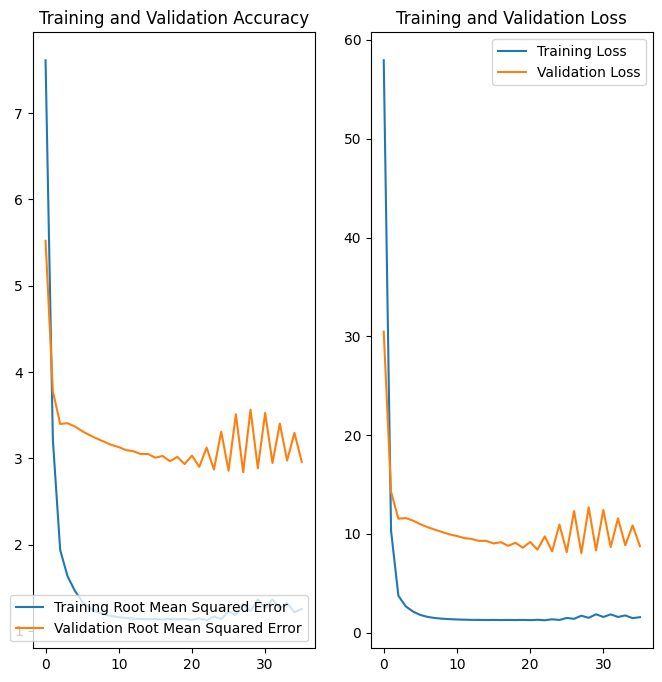

In [31]:
# code for plotting the results from the model for loss and root mean square error
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(36)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

1. Model training is stopped after 36 epochs.

2. High fluctuations are observed in validation accuracy and validation loss curve.

## Model 2

1. Added batch normalization layers.

2. Added dropout layers with dropout rate of 20%.


In [32]:
model2 = Sequential()
model2.add(Dense(128, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(64, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(32, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.01)))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(1, kernel_initializer='uniform',activation='linear'))
# Compile model

opt = Adam()
model2.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [33]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               9344      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)               

In [34]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)


callbacks_list = [checkpoint, early_stopping]

In [35]:
history = model2.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=100, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
69/73 [===========================>..] - ETA: 0s - loss: 90.8334 - root_mean_squared_error: 9.5307 - r2_score: -75.0596
Epoch 1: val_loss improved from inf to 92.80117, saving model to DMSP2_2023-06-1511_00_13.090340/model-00001-90.76092-9.52685-92.80117-9.63334.h5
73/73 [==============================] - 8s 58ms/step - loss: 90.7609 - root_mean_squared_error: 9.5269 - r2_score: -75.8265 - val_loss: 92.8012 - val_root_mean_squared_error: 9.6333 - val_r2_score: -92.9896
Epoch 2/100
70/73 [===========================>..] - ETA: 0s - loss: 83.0268 - root_mean_squared_error: 9.1119 - r2_score: -68.2101
Epoch 2: val_loss improved from 92.80117 to 77.43843, saving model to DMSP2_2023-06-1511_00_13.090340/model-00002-82.75173-9.09680-77.43843-8.79991.h5
73/73 [==============================] - 6s 79ms/step - loss: 82.7517 - root_mean_squared_error: 9.0968 - r2_score: -68.5165 - val_loss: 77.4384 - val_root_mean_squared_error: 8.7999 - val_r2_score: -77.3914
Epoch 3/100
72/73 [====

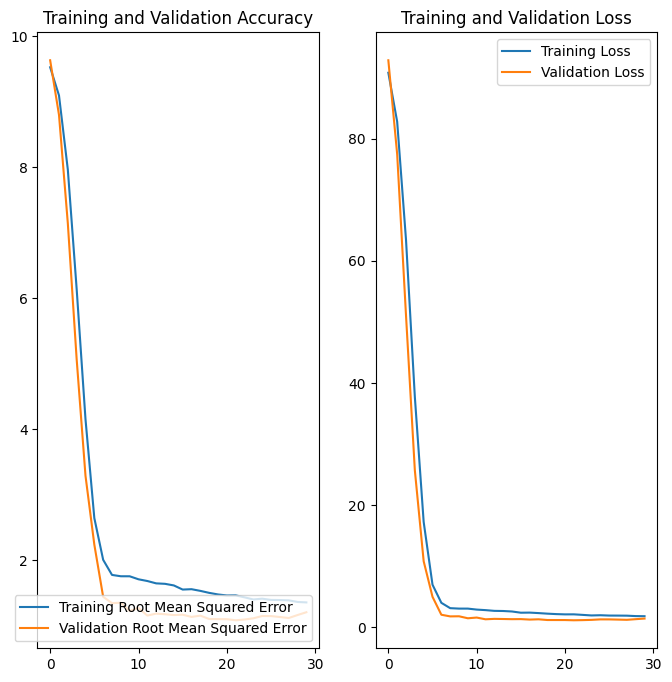

In [36]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

1. With introduction of dropout layers, fluctuations in accuracy curve are decreased.

2. Improved validation RMSE wrt model1.

## Model 3

1. Change parameter alpha for leaky ReLU activation function to 0.02.

2. Add one more hidden layer.

In [37]:
model3 = Sequential()
model3.add(Dense(128, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(64, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.02)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(32, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.02)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(16, kernel_initializer='uniform', activation=keras.layers.LeakyReLU(alpha=0.02)))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(1, kernel_initializer='uniform',activation='linear'))
# Compile model

opt = Adam(0.0001)
model3.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [38]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               9344      
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 64)               

In [39]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP3' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)

# LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, early_stopping]

In [40]:
history = model3.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=100, batch_size=100, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
41/47 [=========================>....] - ETA: 0s - loss: 92.2274 - root_mean_squared_error: 9.6035 - r2_score: -71.0977
Epoch 1: val_loss improved from inf to 97.41936, saving model to DMSP3_2023-06-1511_22_19.108378/model-00001-92.39585-9.61228-97.41936-9.87012.h5
47/47 [==============================] - 9s 71ms/step - loss: 92.3959 - root_mean_squared_error: 9.6123 - r2_score: -73.1791 - val_loss: 97.4194 - val_root_mean_squared_error: 9.8701 - val_r2_score: -95.9070
Epoch 2/100
46/47 [============================>.] - ETA: 0s - loss: 92.2652 - root_mean_squared_error: 9.6055 - r2_score: -72.9011
Epoch 2: val_loss improved from 97.41936 to 97.40302, saving model to DMSP3_2023-06-1511_22_19.108378/model-00002-92.28519-9.60652-97.40302-9.86930.h5
47/47 [==============================] - 2s 46ms/step - loss: 92.2852 - root_mean_squared_error: 9.6065 - r2_score: -73.0909 - val_loss: 97.4030 - val_root_mean_squared_error: 9.8693 - val_r2_score: -95.8906
Epoch 3/100
41/47 [====

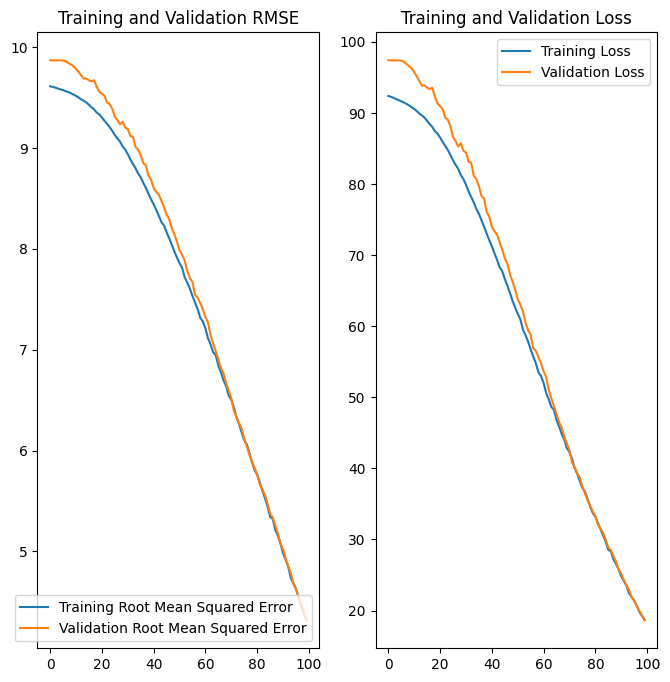

In [41]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

Performance of model is not improved. RMSE value increased.

## Model 4

1. Add more one more layer.

2. Use kernel initilizer as normal instead of uniform.

In [26]:
model4 = Sequential()
model4.add(Dense(256, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
model4.add(Dense(128, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
model4.add(Dense(64, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
model4.add(Dense(32, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
model4.add(Dense(16, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
model4.add(Dense(1, kernel_initializer='normal',activation='linear'))
# Compile model

opt = Adam(0.001)
model4.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [29]:
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               18688     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [30]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


callbacks_list = [checkpoint, early_stopping]

In [31]:
history = model4.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=100, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
73/73 [==============================] - ETA: 0s - loss: 91.2408 - root_mean_squared_error: 9.5520 - r2_score: -76.2697
Epoch 1: val_loss improved from inf to 94.59146, saving model to DMSP4_2023-06-1512_02_25.081013/model-00001-91.24082-9.55201-94.59146-9.72581.h5
73/73 [==============================] - 18s 95ms/step - loss: 91.2408 - root_mean_squared_error: 9.5520 - r2_score: -76.2697 - val_loss: 94.5915 - val_root_mean_squared_error: 9.7258 - val_r2_score: -94.8190
Epoch 2/100
73/73 [==============================] - ETA: 0s - loss: 86.4570 - root_mean_squared_error: 9.2982 - r2_score: -71.9591
Epoch 2: val_loss improved from 94.59146 to 86.72672, saving model to DMSP4_2023-06-1512_02_25.081013/model-00002-86.45703-9.29823-86.72672-9.31272.h5
73/73 [==============================] - 6s 76ms/step - loss: 86.4570 - root_mean_squared_error: 9.2982 - r2_score: -71.9591 - val_loss: 86.7267 - val_root_mean_squared_error: 9.3127 - val_r2_score: -86.7378
Epoch 3/100
73/73 [===

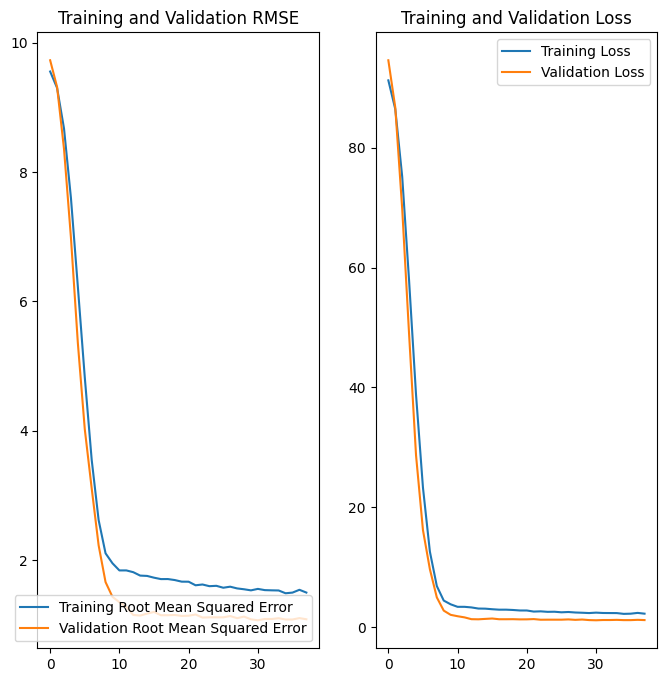

In [32]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(38)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations:**

1. Model training is stopped after 38 epochs. As we used kernel_initializer='normal', model training became faster.

2. Validation RMSE is improved.

# Model X
Lets try with 8 hidden layers deep learning model with dropout=0.1, learning rate = 0.001 as discussed in a manuscript.

In [27]:
modelx = Sequential()
modelx.add(Dense(1024, input_shape=(X_train_scaled.shape[1:]), kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.001)))
modelx.add(BatchNormalization())
modelx.add(Dense(512, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
modelx.add(BatchNormalization())
modelx.add(Dropout(0.1))
modelx.add(Dense(256, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
modelx.add(BatchNormalization())
modelx.add(Dropout(0.1))
modelx.add(Dense(128, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
modelx.add(BatchNormalization())
modelx.add(Dropout(0.1))
modelx.add(Dense(64, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
modelx.add(BatchNormalization())
modelx.add(Dropout(0.1))
modelx.add(Dense(32, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
modelx.add(BatchNormalization())
modelx.add(Dropout(0.1))
modelx.add(Dense(16, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
modelx.add(BatchNormalization())
modelx.add(Dropout(0.1))
modelx.add(Dense(8, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
modelx.add(BatchNormalization())
modelx.add(Dropout(0.1))
modelx.add(Dense(4, kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.02)))
modelx.add(BatchNormalization())
modelx.add(Dropout(0.1))
modelx.add(Dense(1, kernel_initializer='normal',activation='linear'))
# Compile model

opt = Adam(0.001)
modelx.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [28]:
modelx.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1024)              74752     
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)              

In [30]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)


callbacks_list = [checkpoint, early_stopping]

In [31]:
history = modelx.fit(X_train_scaled,y_train_log, validation_data=(X_val_scaled, y_val_log), epochs=500, batch_size=64, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/500
73/73 [==============================] - ETA: 0s - loss: 91.5949 - root_mean_squared_error: 9.5705 - r2_score: -76.6225
Epoch 1: val_loss improved from inf to 95.49679, saving model to DMSP4_2023-06-1610_52_23.290622/model-00001-91.59494-9.57052-95.49679-9.77225.h5
73/73 [==============================] - 13s 98ms/step - loss: 91.5949 - root_mean_squared_error: 9.5705 - r2_score: -76.6225 - val_loss: 95.4968 - val_root_mean_squared_error: 9.7722 - val_r2_score: -95.7423
Epoch 2/500
71/73 [============================>.] - ETA: 0s - loss: 89.0199 - root_mean_squared_error: 9.4350 - r2_score: -74.2591
Epoch 2: val_loss improved from 95.49679 to 92.10268, saving model to DMSP4_2023-06-1610_52_23.290622/model-00002-88.96890-9.43233-92.10268-9.59701.h5
73/73 [==============================] - 7s 90ms/step - loss: 88.9689 - root_mean_squared_error: 9.4323 - r2_score: -74.3014 - val_loss: 92.1027 - val_root_mean_squared_error: 9.5970 - val_r2_score: -92.2873
Epoch 3/500
73/73 [===

**Save model**

In [34]:
from keras.models import load_model
modelx.save("NN_10layer.h5")


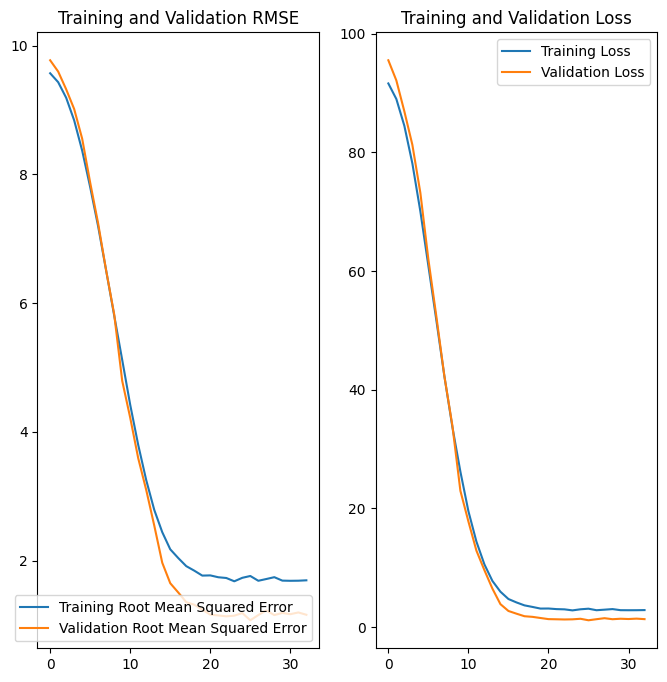

In [33]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(33)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 5

As LSTM works good with sequential data, we will use LSTM in this model with single hidden layer and analyze the performance.

In [26]:
# as LSTM takes input in a particular format, we reshape the training and validation data
import numpy
train_X = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
#train_X = numpy.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
val_X = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

In [27]:
train_X

array([[[-1.30257863, -1.44256422, -0.01681795, ...,  0.19012527,
         -0.47749414,  0.49201846]],

       [[-1.02490731, -1.44256422, -0.02344413, ...,  0.19012527,
         -0.47749414,  0.49201846]],

       [[-0.2096066 , -1.44256422, -0.04327734, ...,  0.26407863,
         -0.65848259,  0.39562449]],

       ...,

       [[-1.06705786,  1.17351305, -1.15843804, ..., -0.54940832,
         -1.01830487, -1.22824303]],

       [[-1.37707409,  1.17351305, -1.15688476, ..., -0.54940832,
         -1.01830487, -1.22824303]],

       [[-1.68007419,  1.17351305, -1.15530243, ..., -0.54940832,
         -1.01830487, -1.22824303]]])

In [26]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(Dense(1, activation='linear'))

opt = Adam(0.001)
model_lstm.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [27]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                35072     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 35,137
Trainable params: 35,137
Non-trainable params: 0
_________________________________________________________________


In [28]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


callbacks_list = [checkpoint, early_stopping]

In [29]:
history = model_lstm.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=100, batch_size=128, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
36/37 [============================>.] - ETA: 0s - loss: 90.2519 - root_mean_squared_error: 9.5001 - r2_score: -70.5007
Epoch 1: val_loss improved from inf to 88.83187, saving model to DMSP6_2023-06-1514_49_04.842395/model-00001-90.26804-9.50095-88.83187-9.42507.h5
37/37 [==============================] - 10s 64ms/step - loss: 90.2680 - root_mean_squared_error: 9.5009 - r2_score: -70.6549 - val_loss: 88.8319 - val_root_mean_squared_error: 9.4251 - val_r2_score: -86.6274
Epoch 2/100
27/37 [====================>.........] - ETA: 0s - loss: 79.1983 - root_mean_squared_error: 8.8993 - r2_score: -56.5370
Epoch 2: val_loss improved from 88.83187 to 77.35055, saving model to DMSP6_2023-06-1514_49_04.842395/model-00002-78.67816-8.87007-77.35055-8.79492.h5
37/37 [==============================] - 1s 37ms/step - loss: 78.6782 - root_mean_squared_error: 8.8701 - r2_score: -61.3493 - val_loss: 77.3505 - val_root_mean_squared_error: 8.7949 - val_r2_score: -75.2347
Epoch 3/100
28/37 [===

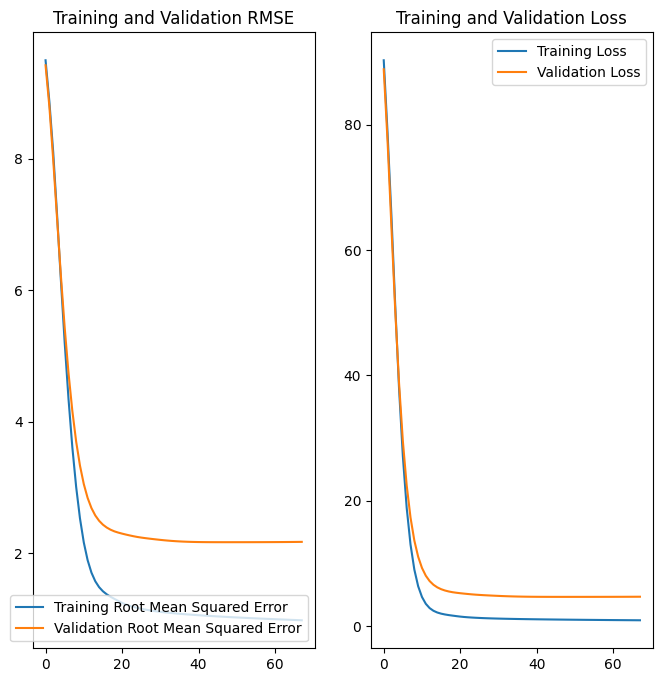

In [31]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(68)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 6

1. Add dropout layer to avoid overfitting.

2. Add dense layer.

In [32]:
model_lstm2 = Sequential()
model_lstm2.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm2.add(Dropout(0.8))
model_lstm2.add(Dense(32, activation=keras.layers.LeakyReLU(alpha=0.02)))
model_lstm2.add(Dropout(0.8))
model_lstm2.add(Dense(1, activation='linear'))
opt = Adam(0.001)
model_lstm2.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [33]:
model_lstm2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                35072     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 37,185
Trainable params: 37,185
Non-trainable params: 0
_________________________________________________________________


In [34]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

callbacks_list = [checkpoint, early_stopping]

In [35]:
history = model_lstm2.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=100, batch_size=128, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
34/37 [==========================>...] - ETA: 0s - loss: 85.3941 - root_mean_squared_error: 9.2409 - r2_score: -65.6734
Epoch 1: val_loss improved from inf to 83.57985, saving model to DMSP7_2023-06-1515_02_02.370372/model-00001-85.26631-9.23398-83.57985-9.14220.h5
37/37 [==============================] - 5s 55ms/step - loss: 85.2663 - root_mean_squared_error: 9.2340 - r2_score: -66.5989 - val_loss: 83.5798 - val_root_mean_squared_error: 9.1422 - val_r2_score: -81.5727
Epoch 2/100
35/37 [===========================>..] - ETA: 0s - loss: 72.2361 - root_mean_squared_error: 8.4992 - r2_score: -55.4445
Epoch 2: val_loss improved from 83.57985 to 66.84162, saving model to DMSP7_2023-06-1515_02_02.370372/model-00002-71.89531-8.47911-66.84162-8.17567.h5
37/37 [==============================] - 1s 40ms/step - loss: 71.8953 - root_mean_squared_error: 8.4791 - r2_score: -55.6518 - val_loss: 66.8416 - val_root_mean_squared_error: 8.1757 - val_r2_score: -64.9986
Epoch 3/100
35/37 [====

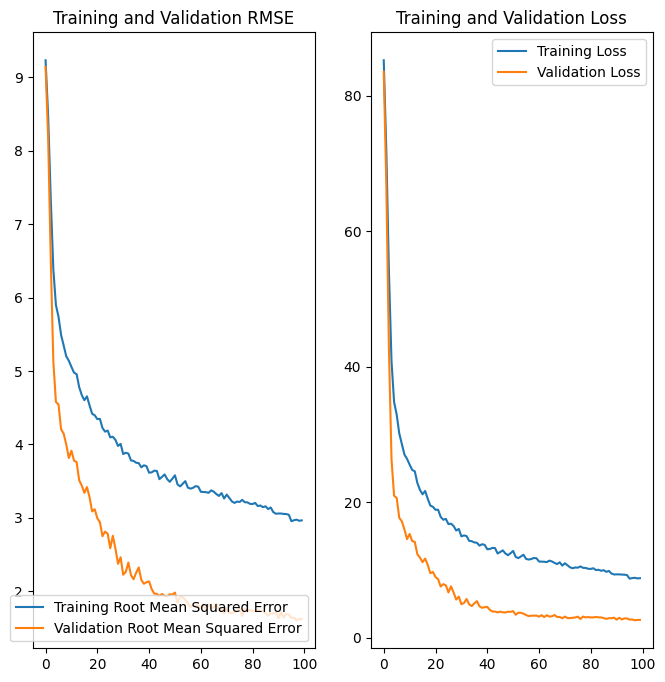

In [36]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 7

Try with multiple dense layers.

In [37]:
model_lstm3 = Sequential()
model_lstm3.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm3.add(Dropout(0.2))
model_lstm3.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.2))
model_lstm3.add(Dense(32, activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.2))
model_lstm3.add(Dense(16, activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.2))
model_lstm3.add(Dense(8, activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm3.add(Dropout(0.2))
model_lstm3.add(Dense(1, activation='linear'))
opt = Adam(0.001)
model_lstm3.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [38]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


callbacks_list = [checkpoint, early_stopping]

In [39]:
history = model_lstm3.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=100, batch_size=128, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 91.7918 - root_mean_squared_error: 9.5808 - r2_score: -71.7208
Epoch 1: val_loss improved from inf to 95.28013, saving model to DMSP8_2023-06-1515_18_21.166655/model-00001-91.79181-9.58080-95.28013-9.76115.h5
37/37 [==============================] - 7s 91ms/step - loss: 91.7918 - root_mean_squared_error: 9.5808 - r2_score: -71.7208 - val_loss: 95.2801 - val_root_mean_squared_error: 9.7612 - val_r2_score: -92.5959
Epoch 2/100
32/37 [========================>.....] - ETA: 0s - loss: 84.4790 - root_mean_squared_error: 9.1912 - r2_score: -63.3284
Epoch 2: val_loss improved from 95.28013 to 65.88070, saving model to DMSP8_2023-06-1515_18_21.166655/model-00002-81.18039-9.01002-65.88070-8.11669.h5
37/37 [==============================] - 1s 41ms/step - loss: 81.1804 - root_mean_squared_error: 9.0100 - r2_score: -61.4594 - val_loss: 65.8807 - val_root_mean_squared_error: 8.1167 - val_r2_score: -61.7124
Epoch 3/100
31/37 [====

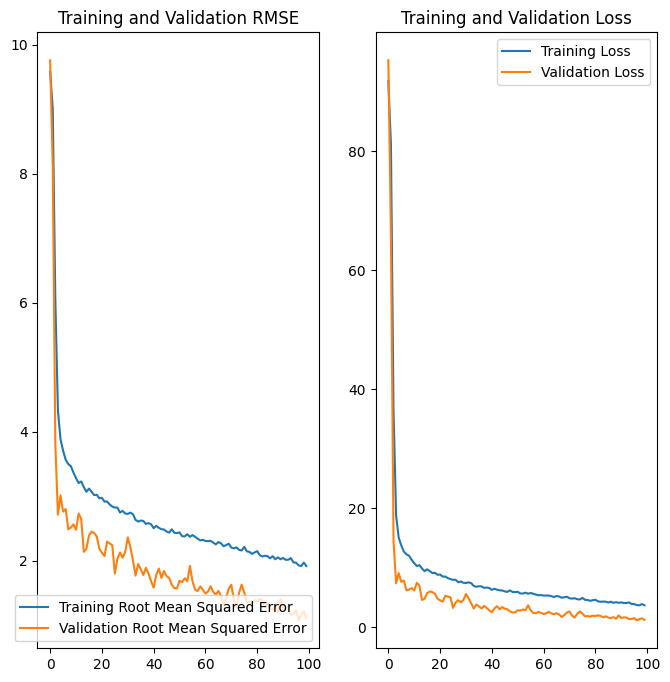

In [41]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 8

1. Add kernel initilizer =normal

2. Add one more LSTM layer.


In [31]:
model_lstm4 = Sequential()
model_lstm4.add(LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm4.add(Dropout(0.2))
model_lstm4.add(LSTM(64, return_sequences=True))
model_lstm4.add(Dropout(0.2))
model_lstm4.add(Dense(32,kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm4.add(Dropout(0.2))
model_lstm4.add(Dense(16,kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm4.add(Dropout(0.2))
model_lstm4.add(Dense(8,kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm4.add(Dropout(0.2))
model_lstm4.add(Dense(1, activation='linear'))
opt = Adam(0.001)
model_lstm4.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [32]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


callbacks_list = [checkpoint, early_stopping]

In [33]:
history = model_lstm4.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=100, batch_size=128, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/100
34/37 [==========================>...] - ETA: 0s - loss: 90.7499 - root_mean_squared_error: 9.5263 - r2_score: -69.6904
Epoch 1: val_loss improved from inf to 90.80974, saving model to DMSP8_2023-06-1517_31_19.767644/model-00001-90.63443-9.52021-90.80974-9.52941.h5
37/37 [==============================] - 15s 106ms/step - loss: 90.6344 - root_mean_squared_error: 9.5202 - r2_score: -70.7041 - val_loss: 90.8097 - val_root_mean_squared_error: 9.5294 - val_r2_score: -88.2545
Epoch 2/100
33/37 [=========================>....] - ETA: 0s - loss: 60.9231 - root_mean_squared_error: 7.8053 - r2_score: -43.1130
Epoch 2: val_loss improved from 90.80974 to 12.96675, saving model to DMSP8_2023-06-1517_31_19.767644/model-00002-56.62506-7.52496-12.96675-3.60094.h5
37/37 [==============================] - 6s 157ms/step - loss: 56.6251 - root_mean_squared_error: 7.5250 - r2_score: -39.7259 - val_loss: 12.9667 - val_root_mean_squared_error: 3.6009 - val_r2_score: -10.9748
Epoch 3/100
35/37 [=

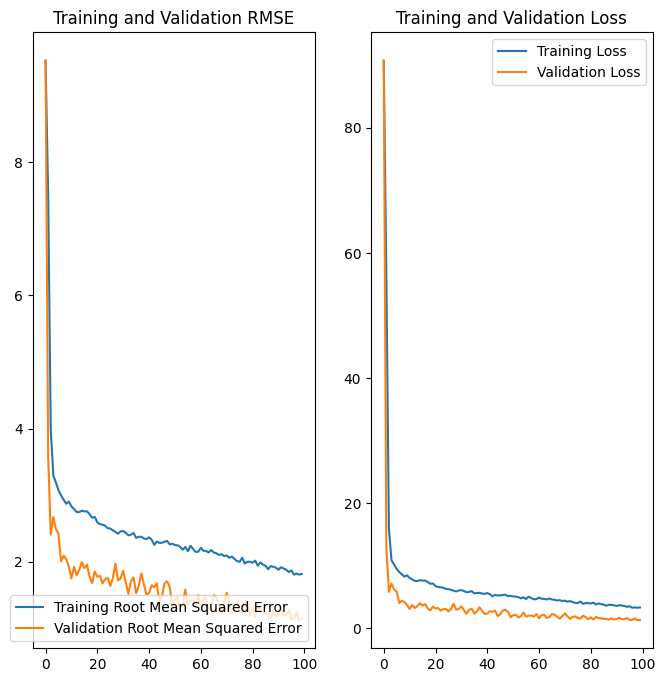

In [34]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 9

1. Add one more LSTM layer with leaky ReLU activation function.

2. Lets run model for more number of epochs.

In [42]:
model_lstm5 = Sequential()
model_lstm5.add(LSTM(128,activation=keras.layers.LeakyReLU(alpha=0.03), return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm5.add(Dropout(0.2))
model_lstm5.add(LSTM(64,activation=keras.layers.LeakyReLU(alpha=0.03), return_sequences=True))
model_lstm5.add(Dropout(0.2))
model_lstm5.add(LSTM(32,activation=keras.layers.LeakyReLU(alpha=0.03), return_sequences=True))
model_lstm5.add(Dropout(0.2))
model_lstm5.add(Dense(16,kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm5.add(Dropout(0.2))
model_lstm5.add(Dense(8,kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm5.add(Dropout(0.2))
model_lstm5.add(Dense(1, activation='linear'))
opt = Adam(0.001)
model_lstm5.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [48]:
model_lstm5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1, 128)            102912    
                                                                 
 dropout_20 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_12 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_21 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_13 (LSTM)              (None, 1, 32)             12416     
                                                                 
 dropout_22 (Dropout)        (None, 1, 32)             0         
                                                                 
 dense_13 (Dense)            (None, 1, 16)            

In [43]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


callbacks_list = [checkpoint, early_stopping]

In [44]:
history = model_lstm5.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=300, batch_size=128, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/300
36/37 [============================>.] - ETA: 0s - loss: 90.7516 - root_mean_squared_error: 9.5264 - r2_score: -70.7238
Epoch 1: val_loss improved from inf to 89.84759, saving model to DMSP8_2023-06-1517_56_26.446211/model-00001-90.72131-9.52477-89.84759-9.47880.h5
37/37 [==============================] - 11s 106ms/step - loss: 90.7213 - root_mean_squared_error: 9.5248 - r2_score: -70.7693 - val_loss: 89.8476 - val_root_mean_squared_error: 9.4788 - val_r2_score: -87.4538
Epoch 2/300
37/37 [==============================] - ETA: 0s - loss: 56.1575 - root_mean_squared_error: 7.4938 - r2_score: -41.0241
Epoch 2: val_loss did not improve from 89.84759
37/37 [==============================] - 3s 88ms/step - loss: 56.1575 - root_mean_squared_error: 7.4938 - r2_score: -41.0241 - val_loss: 159.8637 - val_root_mean_squared_error: 12.6437 - val_r2_score: -133.1271
Epoch 3/300
35/37 [===========================>..] - ETA: 0s - loss: 72.4389 - root_mean_squared_error: 8.5111 - r2_score

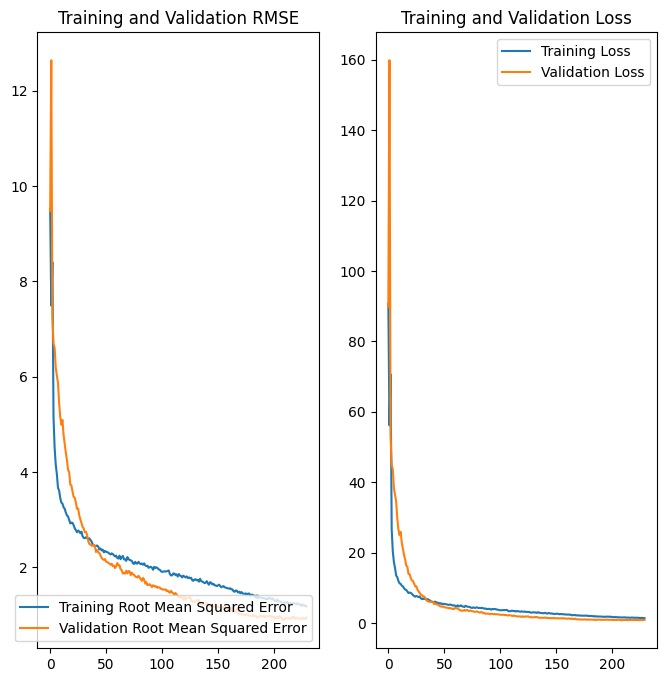

In [45]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(230)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Saving model**

In [49]:
from keras.models import load_model
model_lstm5.save("LSTM_6layer.h5")


# Model 10

Increae number of layers: Added one LSTM and one dense layer keeping other parameters same.

In [50]:
model_lstm6 = Sequential()
model_lstm6.add(LSTM(512,activation=keras.layers.LeakyReLU(alpha=0.03), return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm6.add(Dropout(0.1))
model_lstm6.add(LSTM(256,activation=keras.layers.LeakyReLU(alpha=0.03), return_sequences=True))
model_lstm6.add(Dropout(0.1))
model_lstm6.add(LSTM(128,activation=keras.layers.LeakyReLU(alpha=0.03), return_sequences=True))
model_lstm6.add(Dropout(0.1))
model_lstm6.add(LSTM(64,activation=keras.layers.LeakyReLU(alpha=0.03), return_sequences=True))
model_lstm6.add(Dropout(0.1))
model_lstm6.add(Dense(32,kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm6.add(Dropout(0.1))
model_lstm6.add(Dense(16,kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm6.add(Dropout(0.1))
model_lstm6.add(Dense(8,kernel_initializer='normal', activation=keras.layers.LeakyReLU(alpha=0.03)))
model_lstm6.add(Dropout(0.1))
model_lstm6.add(Dense(1, activation='linear'))
opt = Adam(0.001)
model_lstm6.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None),r2_score])

In [51]:
model_lstm6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1, 512)            1198080   
                                                                 
 dropout_25 (Dropout)        (None, 1, 512)            0         
                                                                 
 lstm_15 (LSTM)              (None, 1, 256)            787456    
                                                                 
 dropout_26 (Dropout)        (None, 1, 256)            0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dropout_27 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_17 (LSTM)              (None, 1, 64)            

In [53]:
curr_dt_time = datetime.datetime.now()
model_name = 'DMSP8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{root_mean_squared_error:.5f}-{val_loss:.5f}-{val_root_mean_squared_error:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


callbacks_list = [checkpoint, early_stopping]

In [54]:
history = model_lstm6.fit(train_X, y_train_log, validation_data=(val_X, y_val_log), epochs=400, batch_size=128, verbose=1, shuffle=False, callbacks=callbacks_list)

Epoch 1/400
35/37 [===========================>..] - ETA: 0s - loss: 87.9138 - root_mean_squared_error: 9.3762 - r2_score: -67.3559
Epoch 1: val_loss improved from inf to 670.71118, saving model to DMSP8_2023-06-1518_35_21.470145/model-00001-86.35200-9.29258-670.71118-25.89809.h5
37/37 [==============================] - 16s 108ms/step - loss: 86.3520 - root_mean_squared_error: 9.2926 - r2_score: -65.9583 - val_loss: 670.7112 - val_root_mean_squared_error: 25.8981 - val_r2_score: -598.0046
Epoch 2/400
35/37 [===========================>..] - ETA: 0s - loss: 145.4479 - root_mean_squared_error: 12.0602 - r2_score: -94.2451 
Epoch 2: val_loss improved from 670.71118 to 73.11124, saving model to DMSP8_2023-06-1518_35_21.470145/model-00002-140.75685-11.86410-73.11124-8.55051.h5
37/37 [==============================] - 3s 86ms/step - loss: 140.7569 - root_mean_squared_error: 11.8641 - r2_score: -89.8773 - val_loss: 73.1112 - val_root_mean_squared_error: 8.5505 - val_r2_score: -65.7992
Epoch 3

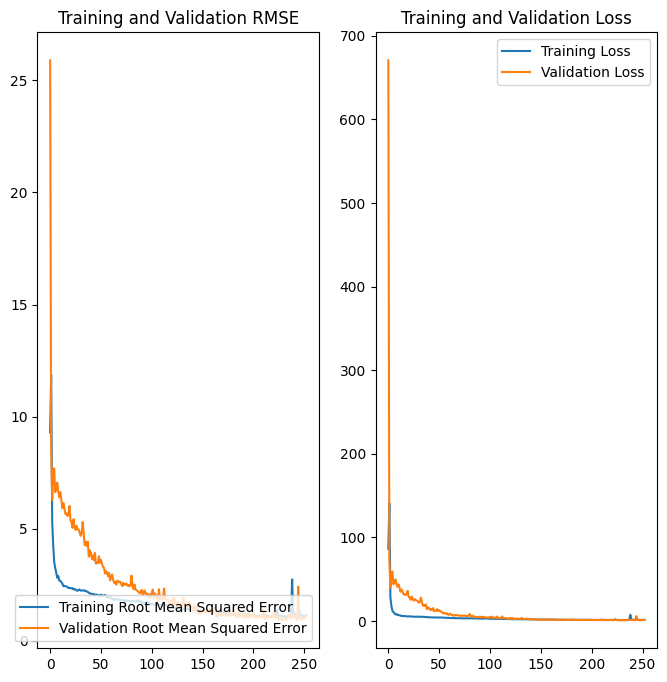

In [55]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(253)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rmse, label='Training Root Mean Squared Error')
plt.plot(epochs_range, val_rmse, label='Validation Root Mean Squared Error')
plt.legend(loc='lower right')
plt.title('Training and Validation RMSE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
model_lstm6.save("LSTM_8layer.h5")

# Conclusion:

  With use of different types of network it is observed that models with LSTM layers is giving good result on basis of validation RMSE. With increase in LSTM layers performance of model is improving. Use of dropout layer reduces fluctuations in accuracy vs epoch curve is decreased. Keeping dropout rate lesser than 20 % is giving good result.


